[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
array([[  0.        ,   0.        ],
       [  4.69031997,   5.87852948],
       [-12.19396993,  -8.13862192],
       [  0.79900252,  -1.9765162 ],
       [ -0.10500723,  -5.33152455],
       [  5.49623734,   4.8611996 ],
       [  0.41269186,   7.04525754],
       [  2.92193339,  -5.37057789],
       [  2.3046924 ,  -5.99301626],
       [  5.49031438,  -0.31203694],
       [ -1.15538977,  -4.25580965],
       [  7.64088337,  -0.96580926],
       [ -2.67704889,  -2.20083469],
       [  3.32693241,   2.2840254 ],
       [  2.57957882,   2.69263127]])
[(0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (0, 5),
 (0, 6),
 (0, 7),
 (0, 8),
 (0, 9),
 (0, 10),
 (0, 11),
 (0, 12),
 (0, 13),
 (0, 14),
 (1, 0),
 (1, 2),
 (1, 3),
 (1, 4),
 (1, 5),
 (1, 6),
 (1, 7),
 (1, 8),
 (1, 9),
 (1, 10),
 (1, 11),
 (1, 12),
 (1, 13),
 (1, 14),
 (2, 0),
 (2, 1),
 (2, 3),
 (2, 4),
 (2, 5),
 (2, 6),
 (2, 7),
 (2, 8),
 (2, 9),
 (2, 10),
 (2, 11),
 (2, 12),
 (2, 13),
 (2, 14),


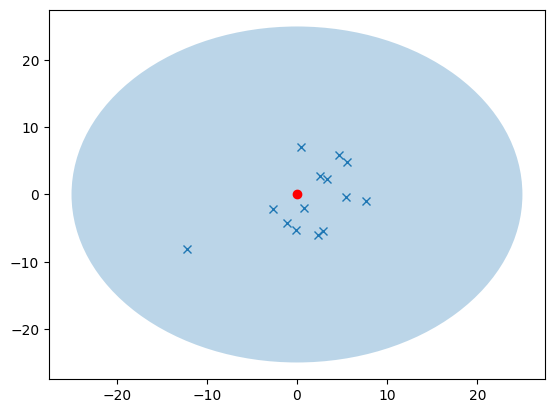

In [17]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
from matplotlib import patches
import pprint

seed = 42
rng = np.random.default_rng(seed)
N = 15
MAX_RANGE = 50
TIME_LIMIT = 40
nodes = list(range(N))
pprint.pprint(nodes)
node_locs = rng.normal(scale=MAX_RANGE / 2 / 4, size=(N, 2))
node_locs[0, :] = 0  # The first node is the depot node (at 0,0)

pprint.pprint(node_locs)
edges = list(edge for edge in itertools.product(nodes, nodes) if edge[0] != edge[1])
pprint.pprint(edges)
distances = [
    np.linalg.norm(node_locs[pt1, :] - node_locs[pt2, :]) for pt1, pt2 in edges
]
distances_dict = {edge: distance for edge, distance in zip(edges, distances)}
pprint.pprint(distances)

plt.gca().add_patch(patches.Circle((0,0), radius=MAX_RANGE / 2, zorder=-10, alpha=0.3))
plt.plot(node_locs[0, 0], node_locs[0, 1], "or")
plt.plot(node_locs[1:, 0], node_locs[1:, 1], "x")



Set parameter TimeLimit to value 40
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (linux64)

CPU model: Intel(R) Core(TM) i7-7700 CPU @ 3.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 452 rows, 225 columns and 1640 nonzeros
Model fingerprint: 0xa6527c58
Variable types: 15 continuous, 210 integer (210 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [9e-01, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+01]
Presolve removed 30 rows and 1 columns
Presolve time: 0.01s
Presolved: 422 rows, 224 columns, 3094 nonzeros
Variable types: 14 continuous, 210 integer (210 binary)
Improved the solution!
Found heuristic solution: objective 124.4233219

Root relaxation: objective 5.068521e+01, 60 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | In

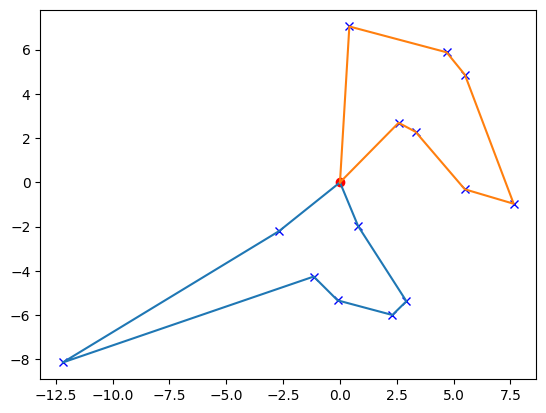

In [18]:
import gurobipy as gp
import matplotlib.pyplot as plt
import networkx as nx

model = gp.Model()
x = model.addVars(edges, obj=distances_dict, vtype=gp.GRB.BINARY, name="x")
r = model.addVars(nodes, vtype=gp.GRB.CONTINUOUS, name="range")

# Conserve flow at depot node
model.addConstr(x.sum(nodes[0], "*") == x.sum("*", nodes[0]))
# Ensure at least one tour goes through the depot
model.addConstr(x.sum(nodes[0], "*") >= 1)
# Set the residual range at the depot to the max
model.addConstr(r[nodes[0]] == MAX_RANGE)

# Only one exit from each non-depot node
model.addConstrs(x.sum(node, "*") == 1 for node in nodes[1:])
# Only one entrance to each non-depot node
model.addConstrs(x.sum("*", node) == 1 for node in nodes[1:])

# Ensure residual range is always enough to complete route
model.addConstrs(r[node] >= distances_dict[node, nodes[0]] for node in nodes[1:])
# Ensure residual range doesn't go above max (may be redundant)
model.addConstrs(r[node] <= MAX_RANGE for node in nodes)
# Constrain the residual range to be propagated through a subtour
# Create equality constraint that only holds when x[i,j] is True (1)
# Don't apply to returning to the depot (j == nodes[0])
model.addConstrs(
    r[j] >= r[i] - distances_dict[i, j] - MAX_RANGE * (1 - x[i, j])
    for i, j in itertools.product(nodes, nodes[1:])
    if i != j
)
model.addConstrs(
    r[j] <= r[i] - distances_dict[i, j] + MAX_RANGE * (1 - x[i, j])
    for i, j in itertools.product(nodes, nodes[1:])
    if i != j
)


def heuristic_solution_cb(model, where, x, nodes, distances):
    if where == gp.GRB.Callback.MIPSOL:
        vals = model.cbGetSolution(x)
        selected = gp.tuplelist((i, j) for i, j in x.keys() if vals[i, j] > 0.5)
        # print(selected)
        # subtours = extract_subtours(selected)
        graph = nx.DiGraph(selected)
        did_improve, improved_solution = improve_solution(graph, x, nodes, distances)
        if did_improve:
            model.cbSetSolution(x, improved_solution)


def extract_subtours(selected):
    graph = nx.DiGraph(selected)
    subtours = []
    visited = set()
    visited.add(nodes[0])
    for next_node in graph.successors(nodes[0]):
        subtour = [nodes[0]]
        while next_node != nodes[0]:
            subtour.append(next_node)
            visited.add(next_node)
            next_nodes = list(graph.successors(next_node))
            assert len(next_nodes) == 1
            next_node = next_nodes[0]
        subtours.append(subtour)

    for node in nodes[1:]:
        if node in visited:
            continue
        subtour = [node]
        next_nodes = list(graph.successors(node))
        assert len(next_nodes) == 1
        next_node = next_nodes[0]
        while next_node != node:
            subtour.append(next_node)
            visited.add(next_node)
            next_nodes = list(graph.successors(next_node))
            assert len(next_nodes) == 1
            next_node = next_nodes[0]
        subtours.append(subtour)
    return subtours


def improve_solution(subtour_graph, x, nodes, distances):
    improved_solution = False
    for node in subtour_graph.nodes:
        if node == nodes[0]:
            continue
        prev_ = next(subtour_graph.predecessors(node))
        next_ = next(subtour_graph.successors(node))
        improvements = []
        for other_node in subtour_graph.nodes:
            if node == other_node:
                continue
            other_next = next(subtour_graph.successors(other_node))
            curr_cost = (
                distances[prev_, node]
                + distances[node, next_]
                + distances[other_node, other_next]
            )
            try:
                swapped_cost = (
                    distances[other_node, node]
                    + distances[node, other_next]
                    + distances[prev_, next_]
                )
            except KeyError:
                continue
            cost_improvement = curr_cost - swapped_cost
            improvements.append((cost_improvement, (other_node, other_next)))
        if not improvements:
            continue
        max_improvement = max(improvements, key=lambda x: x[0])
        if max_improvement[0] > 0:
            improved_solution = True
            subtour_graph.remove_edges_from(
                ((prev_, node), (node, next_), max_improvement[1])
            )
            new_prev, new_next = max_improvement[1]
            subtour_graph.add_edges_from(
                ((prev_, next_), (new_prev, node), (node, new_next))
            )
    solution = {}
    for i, j in x:
        if subtour_graph.has_edge(i, j):
            solution[i, j] = 1
        else:
            solution[i, j] = 0
    if improved_solution:
        print("Improved the solution!")
    return improved_solution, solution


# model.Params.LazyConstraints = 1
# model.Params.OutputFlag = 0
model.Params.TimeLimit = TIME_LIMIT
model.optimize(
    lambda model, where: heuristic_solution_cb(
        model, where, x=x, nodes=nodes, distances=distances_dict
    )
)

vals = model.getAttr("x", x)
selected = gp.tuplelist((i, j) for i, j in vals.keys() if vals[i, j] > 0.5)
# print(selected)
tours = extract_subtours(selected)
print(tours)
plt.plot(node_locs[0, 0], node_locs[0, 1], "or")
plt.plot(node_locs[1:, 0], node_locs[1:, 1], "xb")
for tour in tours:
    pts = np.zeros((len(tour) + 1, 2))
    for idx, node in enumerate(tour):
        pts[idx] = node_locs[node]
    pts[-1] = node_locs[0]
    plt.plot(pts[:, 0], pts[:, 1])


Set parameter TimeLimit to value 40
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (linux64)

CPU model: Intel(R) Core(TM) i7-7700 CPU @ 3.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 452 rows, 225 columns and 1640 nonzeros
Model fingerprint: 0xa6527c58
Variable types: 15 continuous, 210 integer (210 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [9e-01, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+01]
Presolve removed 30 rows and 1 columns
Presolve time: 0.01s
Presolved: 422 rows, 224 columns, 3094 nonzeros
Variable types: 14 continuous, 210 integer (210 binary)
Improved the solution!
Found heuristic solution: objective 124.4233219

Root relaxation: objective 5.068521e+01, 60 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | In

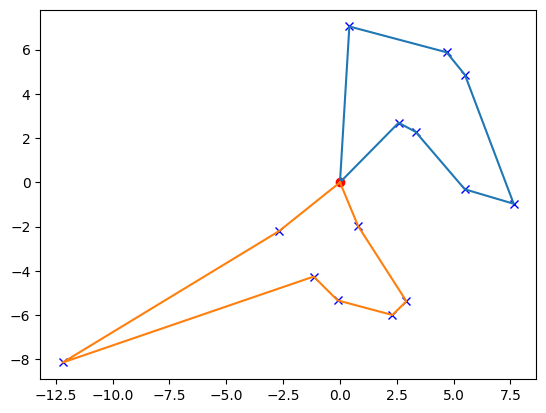

In [19]:
import verypy.util
import verypy.local_search
from verypy.local_search import inter_route_operators, intra_route_operators

import gurobipy as gp
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

model = gp.Model()
x = model.addVars(edges, obj=distances_dict, vtype=gp.GRB.BINARY, name="x")
r = model.addVars(nodes, vtype=gp.GRB.CONTINUOUS, name="range")

# Conserve flow at depot node
model.addConstr(x.sum(nodes[0], "*") == x.sum("*", nodes[0]))
# Ensure at least one tour goes through the depot
model.addConstr(x.sum(nodes[0], "*") >= 1)
# Set the residual range at the depot to the max
model.addConstr(r[nodes[0]] == MAX_RANGE)

# Only one exit from each non-depot node
model.addConstrs(x.sum(node, "*") == 1 for node in nodes[1:])
# Only one entrance to each non-depot node
model.addConstrs(x.sum("*", node) == 1 for node in nodes[1:])

# Ensure residual range is always enough to complete route
model.addConstrs(r[node] >= distances_dict[node, nodes[0]] for node in nodes[1:])
# Ensure residual range doesn't go above max (may be redundant)
model.addConstrs(r[node] <= MAX_RANGE for node in nodes)
# Constrain the residual range to be propagated through a subtour
# Create equality constraint that only holds when x[i,j] is True (1)
# Don't apply to returning to the depot (j == nodes[0])
model.addConstrs(
    r[j] >= r[i] - distances_dict[i, j] - MAX_RANGE * (1 - x[i, j])
    for i, j in itertools.product(nodes, nodes[1:])
    if i != j
)
model.addConstrs(
    r[j] <= r[i] - distances_dict[i, j] + MAX_RANGE * (1 - x[i, j])
    for i, j in itertools.product(nodes, nodes[1:])
    if i != j
)


def heuristic_solution_cb(model, where, x, nodes, distances):
    if where == gp.GRB.Callback.MIPSOL:
        vals = model.cbGetSolution(x)
        selected = gp.tuplelist((i, j) for i, j in x.keys() if vals[i, j] > 0.5)
        # print(selected)
        subtours = extract_subtours(selected)
        # graph = nx.DiGraph(selected)
        did_improve, improved_solution = improve_solution(subtours, x, nodes, distances)
        if did_improve:
            model.cbSetSolution(x, improved_solution)


def extract_subtours(selected):
    graph = nx.DiGraph(selected)
    subtours = []
    visited = set()
    visited.add(nodes[0])
    for next_node in graph.successors(nodes[0]):
        subtour = [nodes[0]]
        while next_node != nodes[0]:
            subtour.append(next_node)
            visited.add(next_node)
            next_nodes = list(graph.successors(next_node))
            assert len(next_nodes) == 1
            next_node = next_nodes[0]
        subtours.append(subtour)

    for node in nodes[1:]:
        if node in visited:
            continue
        subtour = [node]
        next_nodes = list(graph.successors(node))
        assert len(next_nodes) == 1
        next_node = next_nodes[0]
        while next_node != node:
            subtour.append(next_node)
            visited.add(next_node)
            next_nodes = list(graph.successors(next_node))
            assert len(next_nodes) == 1
            next_node = next_nodes[0]
        subtours.append(subtour)
    return subtours


def improve_solution(subtours, x, nodes, distances):
    solution = verypy.util.routes2sol(subtours)
    dists = np.zeros((len(nodes), len(nodes)))
    for (i, j), dist in distances.items():
        dists[i, j] = dist
    ls_ops = [inter_route_operators.do_1point_move, inter_route_operators.do_2optstar_move, intra_route_operators.do_2opt_move, intra_route_operators.do_relocate_move]
    new_solution = verypy.local_search.do_local_search(ls_ops, solution, dists, None, None, L=MAX_RANGE, max_iterations=10)
    if new_solution == solution:
        return False, None
    edge_solution = {}
    for node, next_node in zip(new_solution, new_solution[1:]):
        edge_solution[node, next_node] = 1
    for i, j in x:
        if (i, j) not in edge_solution:
            edge_solution[i, j] = 0

    print("Improved the solution!")
    return True, edge_solution


# model.Params.LazyConstraints = 1
# model.Params.OutputFlag = 0
model.Params.TimeLimit = TIME_LIMIT
model.optimize(
    lambda model, where: heuristic_solution_cb(
        model, where, x=x, nodes=nodes, distances=distances_dict
    )
)

vals = model.getAttr("x", x)
selected = gp.tuplelist((i, j) for i, j in vals.keys() if vals[i, j] > 0.5)
# print(selected)
tours = extract_subtours(selected)
print(tours)
plt.plot(node_locs[0, 0], node_locs[0, 1], "or")
plt.plot(node_locs[1:, 0], node_locs[1:, 1], "xb")
for tour in tours:
    pts = np.zeros((len(tour) + 1, 2))
    for idx, node in enumerate(tour):
        pts[idx] = node_locs[node]
    pts[-1] = node_locs[0]
    plt.plot(pts[:, 0], pts[:, 1])


{1: ['Source', 3, 7, 8, 4, 10, 2, 12, 'Sink'], 2: ['Source', 6, 1, 5, 11, 9, 13, 14, 'Sink']}
66.60457035168605


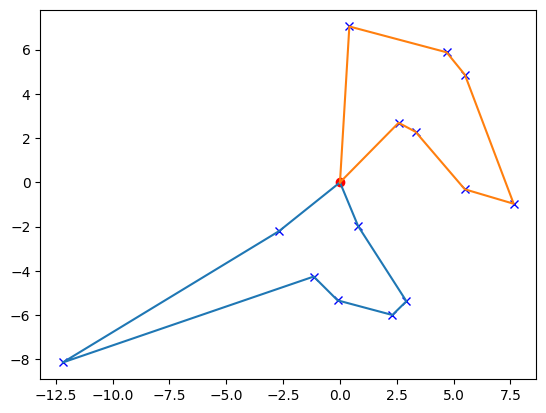

In [20]:
import vrpy

import networkx as nx

graph = nx.DiGraph(
    (i if i != 0 else "Source", j if j != 0 else "Sink", {"cost": distance, "time": distance}) for (i, j), distance in distances_dict.items()
)
problem = vrpy.VehicleRoutingProblem(graph, duration=MAX_RANGE)
problem.solve(time_limit=TIME_LIMIT)
print(problem.best_routes)
print(sum(problem.best_routes_cost.values()))
plt.plot(node_locs[0, 0], node_locs[0, 1], "or")
plt.plot(node_locs[1:, 0], node_locs[1:, 1], "xb")
for _, tour in problem.best_routes.items():
    pts = np.zeros((len(tour) + 1, 2))
    for idx, node in enumerate(tour):
        pts[idx] = node_locs[0 if node in {"Source", "Sink"} else node]
    pts[-1] = node_locs[0]
    plt.plot(pts[:, 0], pts[:, 1])

Set parameter TimeLimit to value 40


Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (linux64)

CPU model: Intel(R) Core(TM) i7-7700 CPU @ 3.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 437 rows, 225 columns and 1625 nonzeros
Model fingerprint: 0x0eac8a66
Variable types: 15 continuous, 210 integer (210 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [3e-02, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+01]
Found heuristic solution: objective 0.0000000
Presolve removed 29 rows and 0 columns
Presolve time: 0.00s
Presolved: 408 rows, 225 columns, 1769 nonzeros
Variable types: 15 continuous, 210 integer (210 binary)

Root relaxation: objective -6.202399e+02, 363 iterations, 0.01 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 -620.2

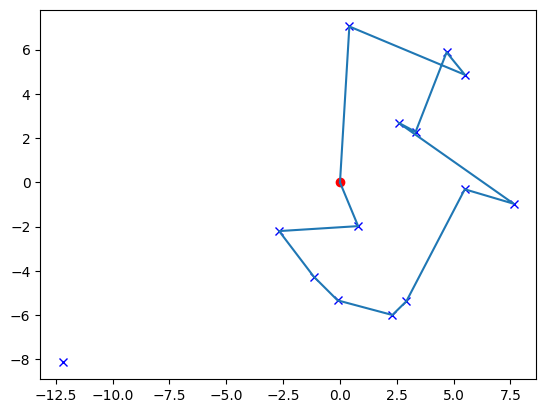

In [21]:
import gurobipy as gp

model = gp.Model()
max_depot_dist = max(distances_dict[0, i] for i in nodes[1:])
costs = {(i, j): distance - 2 * (distances_dict[0, i] if i != 0 else 0) for (i, j), distance in distances_dict.items()}
x = model.addVars(edges, obj=costs, vtype=gp.GRB.BINARY, name="x")
r = model.addVars(nodes, vtype=gp.GRB.CONTINUOUS, name="d")
model.addConstr(x.sum(nodes[0], "*") == 1)
model.addConstr(x.sum("*", nodes[0]) == 1)
model.addConstrs(x.sum(i, "*") == x.sum("*", i) for i in nodes[1:])
# Ensure residual range is always enough to complete route
model.addConstrs(r[node] >= distances_dict[node, nodes[0]] for node in nodes[1:])
# Ensure residual range doesn't go above max (may be redundant)
model.addConstrs(r[node] <= MAX_RANGE for node in nodes)
# Constrain the residual range to be propagated through a subtour
# Create equality constraint that only holds when x[i,j] is True (1)
# Don't apply to returning to the depot (j == nodes[0])
model.addConstrs(
    r[j] >= r[i] - distances_dict[i, j] - MAX_RANGE * (1 - x[i, j])
    for i, j in itertools.product(nodes, nodes[1:])
    if i != j
)
model.addConstrs(
    r[j] <= r[i] - distances_dict[i, j] + MAX_RANGE * (1 - x[i, j])
    for i, j in itertools.product(nodes, nodes[1:])
    if i != j
)
model.Params.TimeLimit = TIME_LIMIT
model.optimize(
    # lambda model, where: heuristic_solution_cb(
    #     model, where, x=x, nodes=nodes, distances=distances_dict
    # )
)

vals = model.getAttr("x", x)
selected = gp.tuplelist((i, j) for i, j in vals.keys() if vals[i, j] > 0.5)
# print(selected)
graph = nx.DiGraph(selected)
cycle = nx.find_cycle(graph)
tour = [i for i, _ in cycle] + [nodes[0]]
plt.plot(node_locs[0, 0], node_locs[0, 1], "or")
plt.plot(node_locs[1:, 0], node_locs[1:, 1], "xb")
pts = np.zeros((len(tour) + 1, 2))
for idx, node in enumerate(tour):
    pts[idx] = node_locs[node]
pts[-1] = node_locs[0]
plt.plot(pts[:, 0], pts[:, 1])

['Source', 3, 12, 10, 4, 8, 7, 11, 9, 5, 1, 6, 14, 13, 'Sink']


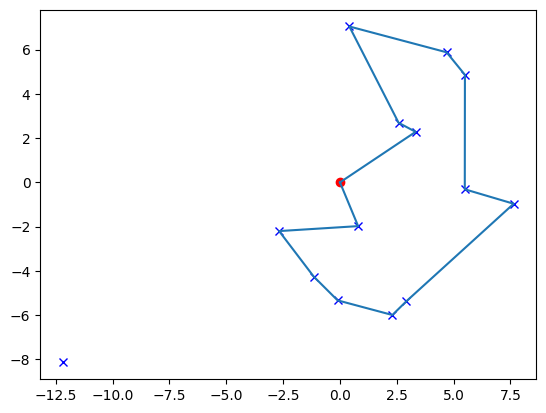

In [22]:
import networkx as nx
import cspy

graph = nx.DiGraph()
graph.graph["n_res"] = 1
total_depot_dist = sum(distances_dict[0, i] for i in nodes[1:])
graph.add_edges_from(
    (
        i if i != nodes[0] else "Source", 
        j if j != nodes[0] else "Sink", 
        {
            "weight": (
                d 
                - 2 * (distances_dict[0, i] if i != 0 else 0)
            ),
            "res_cost": [distances_dict[i, j]],
        }
    ) 
    for (i, j), d in distances_dict.items()
)
alg = cspy.BiDirectional(graph, [MAX_RANGE], [0], time_limit=TIME_LIMIT, elementary=True)
alg.run()
tour = alg.path
print(tour)
tour = [i if i not in ["Source", "Sink"] else nodes[0] for i in tour]
plt.plot(node_locs[0, 0], node_locs[0, 1], "or")
plt.plot(node_locs[1:, 0], node_locs[1:, 1], "xb")
pts = np.zeros((len(tour) + 1, 2))
for idx, node in enumerate(tour):
    pts[idx] = node_locs[node]
pts[-1] = node_locs[0]
plt.plot(pts[:, 0], pts[:, 1])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
[array([0., 0.]),
 array([4.69031997, 5.87852948]),
 array([-12.19396993,  -8.13862192]),
 array([ 0.79900252, -1.9765162 ]),
 array([-0.10500723, -5.33152455]),
 array([5.49623734, 4.8611996 ]),
 array([0.41269186, 7.04525754]),
 array([ 2.92193339, -5.37057789]),
 array([ 2.3046924 , -5.99301626]),
 array([ 5.49031438, -0.31203694]),
 array([-1.15538977, -4.25580965]),
 array([ 7.64088337, -0.96580926]),
 array([-2.67704889, -2.20083469]),
 array([3.32693241, 2.2840254 ]),
 array([2.57957882, 2.69263127])]
[(0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (0, 5),
 (0, 6),
 (0, 7),
 (0, 8),
 (0, 9),
 (0, 10),
 (0, 11),
 (0, 12),
 (0, 13),
 (0, 14),
 (1, 0),
 (1, 2),
 (1, 3),
 (1, 4),
 (1, 5),
 (1, 6),
 (1, 7),
 (1, 8),
 (1, 9),
 (1, 10),
 (1, 11),
 (1, 12),
 (1, 13),
 (1, 14),
 (2, 0),
 (2, 1),
 (2, 3),
 (2, 4),
 (2, 5),
 (2, 6),
 (2, 7),
 (2, 8),
 (2, 9),
 (2, 10),
 (2, 11),
 (2, 12),
 (2, 13),
 (2, 14),
 (3, 0),
 (3, 1),
 (3, 2),
 (3, 4),
 (3, 5

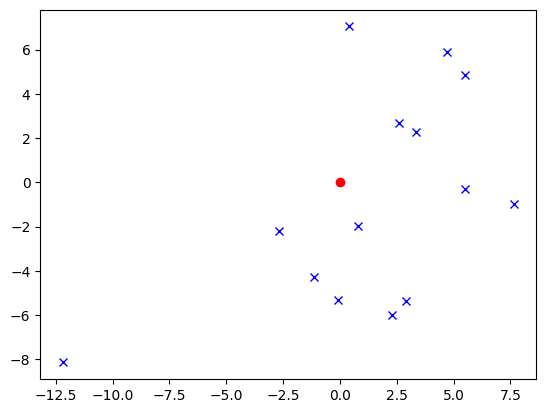

In [23]:
import networkx as nx
import numpy as np
from matplotlib import pyplot as plt, patches
import pprint

G = nx.DiGraph()
rng = np.random.default_rng(seed=42)
for i in range(N):
    if i == 0:
        rng.normal(0, MAX_RANGE / 2 / 4, size=(2,))
        pos = np.array([0.0, 0.0])
    else:
        pos = rng.normal(0, MAX_RANGE / 2 / 4, size=(2,))
    G.add_node(i, pos=pos)
for node, pos in G.nodes.data("pos"):
    for other_node, other_pos in G.nodes.data("pos"):
        if node == other_node:
            continue
        dist = np.linalg.norm(pos - other_pos)
        G.add_edge(node, other_node, weight=dist)
pprint.pprint(list(G.nodes))
pprint.pprint(list(data["pos"] for _, data in G.nodes.data()))
pprint.pprint(list(G.edges))
pprint.pprint(list(data["weight"] for _, _, data in G.edges.data()))

def plot_G(G):
    for node, pos in G.nodes.data("pos"):
        if node == 0:
            plt.plot(pos[0], pos[1], "or")
            continue
        plt.plot(pos[0], pos[1], "xb")

plot_G(G)

In [24]:
def greedy_tour(G: nx.DiGraph):
    furthest = max(G.succ[0].items(), key=lambda x: x[1]["weight"])
    tour = [0, furthest[0], 0]
    next_node, idx = greedy_insertion(G, tour)
    while next_node is not None:
        tour.insert(idx, next_node)
        next_node, idx = greedy_insertion(G, tour)
    return tour


def ellipse_tour(G: nx.DiGraph):
    furthest, furthest_dict = max(G.succ[0].items(), key=lambda x: x[1]["weight"])
    # ---Ellipse params
    a_full = MAX_RANGE / 4
    c_full = furthest_dict["weight"] / 2
    b_full = np.sqrt(a_full**2 - c_full**2)
    a = c_full
    b = b_full
    if a < b:
        a, b = b, a
    c = np.sqrt(a**2 - b**2)
    center = G.nodes[furthest]["pos"] / 2
    angle = np.rad2deg(np.arctan2(center[1], center[0]))
    unit_vec = center / np.linalg.norm(center)
    if c_full < b_full:
        unit_vec = unit_vec[::-1]
        unit_vec[0] = -unit_vec[0]
    f1 = center + c * unit_vec
    f2 = center - c * unit_vec
    # print(a_full, b_full, c_full, a, b, c, center, angle, unit_vec, f1, f2)
    # ---
    # --- Debug plotting
    # plot_ellipse_G(G, furthest, furthest_dict["weight"])
    # plt.gca().add_patch(patches.Ellipse(center, 2*c_full, 2*b_full, angle=angle, zorder=-10, alpha=0.5))
    # plt.plot(f1[0], f1[1], "ok")
    # plt.plot(f2[0], f2[1], "ok")
    # plt.figure()
    # ---
    tour = [0, furthest, 0]
    H = G.copy()
    bad_nodes = []
    for node in list(H.nodes)[1:]:
        if node == furthest:
            continue
        dist1 = np.linalg.norm(f1 - H.nodes[node]["pos"])
        dist2 = np.linalg.norm(f2 - H.nodes[node]["pos"])
        in_ellipse = dist1 + dist2 <= 2 * a
        if not in_ellipse:
            bad_nodes.append(node)
    H.remove_nodes_from(bad_nodes)
    # print(H.nodes)
    # print(H.edges)
    next_node, idx = greedy_insertion(H, tour)
    while next_node is not None:
        tour.insert(idx, next_node)
        next_node, idx = greedy_insertion(H, tour)
    return tour


def greedy_insertion(G: nx.DiGraph, tour: list):
    tour_dist = tour_distance(G, tour)
    best_dist = float("inf")
    best_node = None
    best_idx = None
    for node in G.nodes:
        if node in tour or node == 0:
            continue
        best_node_dist = float("inf")
        best_node_idx = None
        for idx, _ in enumerate(tour[1:], 1):
            prev_node = tour[idx - 1]
            next_node = tour[idx]
            dist = (
                tour_dist
                - G.edges[prev_node, next_node]["weight"]
                + G.edges[prev_node, node]["weight"]
                + G.edges[node, next_node]["weight"]
            )
            if dist < best_node_dist:
                best_node_dist = dist
                best_node_idx = idx
        if best_node_dist < best_dist:
            best_dist = best_node_dist
            best_idx = best_node_idx
            best_node = node
    if best_dist <= MAX_RANGE:
        return best_node, best_idx
    return None, None


def tour_distance(G, tour):
    dist = 0.0
    for node, next_node in zip(tour, tour[1:]):
        dist += G.edges[node, next_node]["weight"]
    return dist


def plot_ellipse_G(G, node, dist):
    c = dist / 2
    a = MAX_RANGE / 4
    b = np.sqrt(a**2 - c**2)
    # print(a, b, c)
    center = G.nodes[node]["pos"] / 2
    angle = np.rad2deg(np.arctan2(center[1], center[0]))
    # print(center, angle)
    plot_G(G)
    plt.gca().add_patch(patches.Ellipse(center, 2*a, 2*b, angle=angle, zorder=-10, alpha=0.5))


def plot_edge(G, i, j, color=None):
    pts = np.zeros((2,2))
    pts[:, 0] = G.nodes[i]["pos"]
    pts[:, 1] = G.nodes[j]["pos"]
    plt.plot(pts[0], pts[1], color="tab:blue" if color is None else color)


def plot_tours(G, tours):
    for tour, color in zip(tours, plt.rcParams['axes.prop_cycle'].by_key()["color"]):
        for i, j in zip(tour, tour[1:]):
            plot_edge(G, i, j, color=color)



-------------Greedy-------------
[[0, 12, 2, 10, 4, 8, 7, 3, 9, 13, 14, 0], [0, 6, 1, 5, 11, 0]]
74.90443954897428


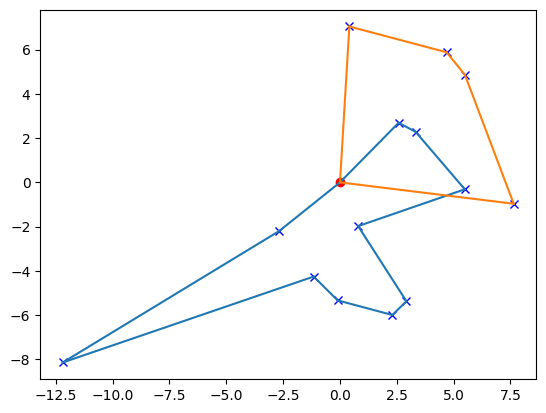

In [25]:
print("-------------Greedy-------------")
H = G.copy()
tours = []
while len(H.nodes) > 1:
    tour = greedy_tour(H)
    H.remove_nodes_from(tour[1:-1])
    tours.append(tour)
print(tours)
print(sum(tour_distance(G, tour) for tour in tours))
plt.figure()
plot_G(G)
plot_tours(G, tours)

------------Ellipse-------------
[[0, 12, 2, 10, 4, 3, 0], [0, 8, 7, 9, 11, 5, 1, 13, 14, 0], [0, 6, 0]]
78.75971154406759


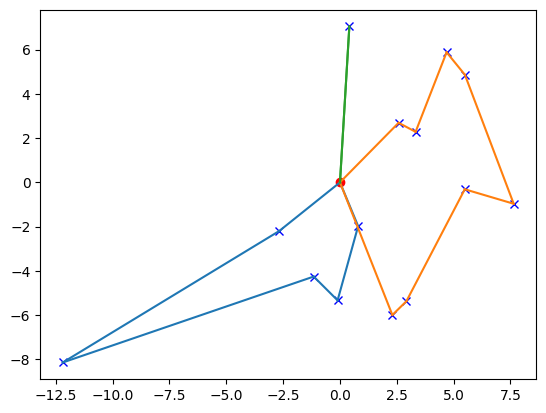

In [26]:
print("------------Ellipse-------------")
H = G.copy()
tours = []
while len(H.nodes) > 1:
    tour = ellipse_tour(H)
    H.remove_nodes_from(tour[1:-1])
    tours.append(tour)
print(tours)
print(sum(tour_distance(G, tour) for tour in tours))

plot_G(G)
plot_tours(G, tours)

[(0, 1, 7.520386311468818), (0, 2, 14.66049348943672), (0, 3, 2.131905561696097), (0, 4, 5.3325585339601345), (0, 5, 7.337566793273379), (0, 6, 7.057334371139096), (0, 7, 6.11398410491806), (0, 8, 6.420891752386194), (0, 9, 5.499174399876728), (0, 10, 4.409857290676069), (0, 11, 7.701680735791899), (0, 12, 3.465582791776542), (0, 13, 4.035498890720706), (0, 14, 3.7288724905897066), (1, 0, 7.520386311468818), (1, 2, 21.94447034594635), (1, 3, 8.76607632617063), (1, 4, 12.19264016823729), (1, 5, 1.2978685960547358), (1, 6, 4.433887308243279), (1, 7, 11.387256374792724), (1, 8, 12.108873481881258), (1, 9, 6.242043228719565), (1, 10, 11.699450928787625), (1, 11, 7.453240713183277), (1, 12, 10.934086578788271), (1, 13, 3.844383591202118), (1, 14, 3.8216718335970485), (2, 0, 14.66049348943672), (2, 1, 21.94447034594635), (2, 3, 14.380155767911155), (2, 4, 12.410592841651535), (2, 5, 21.95310439846201), (2, 6, 19.73519994724734), (2, 7, 15.36725742764883), (2, 8, 14.656562796497294), (2, 9, 1

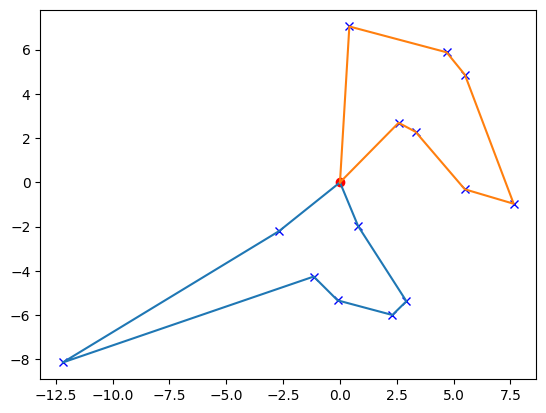

In [27]:
import gurobipy as gp

print(G.edges.data("weight"))
model = gp.Model()
x = model.addVars(
    G.edges,
    obj={(i, j): weight for i, j, weight in G.edges.data("weight")},
    vtype=gp.GRB.BINARY,
    name="x",
)
d = model.addVars(G.nodes)
model.addConstr(x.sum(0, "*") == x.sum("*", 0))
model.addConstr(d[0] == 0)
model.addConstrs(x.sum(i, "*") == 1 for i in list(G.nodes)[1:])
model.addConstrs(x.sum("*", i) == 1 for i in list(G.nodes)[1:])
model.addConstrs(
    d[j] >= d[i] + G.edges[i,j]["weight"] - MAX_RANGE * (1 - x[i, j])
    for i in G.nodes
    for j in list(G.nodes)[1:]
    if i != j
)
# model.addConstrs(
#     d[j] <= d[i] + G.edges[i,j]["weight"] + MAX_RANGE * (1 - x[i, j])
#     for i in G.nodes
#     for j in list(G.nodes)[1:]
#     if i != j
# )
# for i, j, weight in G.edges.data("weight"):
#     if j == 0:
#         continue
#     model.addGenConstrIndicator(x[i, j], True, d[j] == d[i] + weight)
model.addConstrs(d[i] >= 0 for i in list(G.nodes)[1:])
model.addConstrs(
    d[i] <= MAX_RANGE - G.edges[i, 0]["weight"] for i in list(G.nodes)[1:]
)

model.Params.TimeLimit = TIME_LIMIT
model.optimize()
def plot_sol(G, model, x):
    for (i, j), val in model.getAttr("X", x).items():
        if val > 0.5:
            plot_edge(G, i, j)

vals = model.getAttr("x", x)
# print(vals)
selected = gp.tuplelist((i, j) for i, j in vals.keys() if vals[i, j] > 0.5)
print(list(selected))
tours = extract_subtours(selected)
print(tours)
plt.plot(node_locs[0, 0], node_locs[0, 1], "or")
plt.plot(node_locs[1:, 0], node_locs[1:, 1], "xb")
for tour in tours:
    pts = np.zeros((len(tour) + 1, 2))
    for idx, node in enumerate(tour):
        pts[idx] = node_locs[node]
    pts[-1] = node_locs[tour[0]]
    plt.plot(pts[:, 0], pts[:, 1])

In [32]:
# A_eq = np.zeros(((2*len(G.nodes) - 1), len(G.edges)))
# for k, (i, j) in enumerate(G.edges):
#     row_out = i
#     row_in = len(G.nodes) + j - 1
#     if i == 0:
#         A_eq[0, k] = -1
#         A_eq[row_in, k] = 1
#         continue
#     if j == 0:
#         A_eq[0, k] = 1
#         A_eq[row_out, k] = 1
#         continue
#     A_eq[row_in, k] = 1
#     A_eq[row_out, k] = 1

# def indicator(edge_vals):
#     I_x_list = []
#     for i, edge_val in enumerate(edge_vals):
#         if edge_val > 0.5:
#             col = np.zeros((len(edges),1))
#             col[i] = 1
#             I_x_list.append(col)
#     I_x = np.concatenate(I_x_list, axis=1)
#     return I_x

# c = list(weight for _, _, weight in G.edges.data("weight"))
# b_eq = np.ones((A_eq.shape[0],))
# b_eq[0] = 0
# A_ub = np.array([0 if 0 not in edge else -1 for edge in G.edges]).reshape((1, -1))
# b_ub = [-2]


def matrices_from_gurobi(model):
    vars = model.getVars()
    constrs = model.getConstrs()
    bounds, c, b_eq, b_ub, A_eq, A_ub, integrality = [], [], [], [], [], [], []
    for var in vars:
        bounds.append((var.lb, var.ub))
        c.append(var.obj)
        integrality.append(
            int(var.vtype == gp.GRB.BINARY or var.vtype == gp.GRB.INTEGER)
        )
    for constr in constrs:
        row = []
        for var in vars:
            row.append(model.getCoeff(constr, var))
        if constr.sense == "=":
            A_eq.append(row)
            b_eq.append(constr.rhs)
        elif constr.sense == "<":
            A_ub.append(row)
            b_ub.append(constr.rhs)
        elif constr.sense == ">":
            A_ub.append([-val for val in row])
            b_ub.append(-constr.rhs)
    return (
        np.array(c),
        np.array(A_ub),
        np.array(b_ub),
        np.array(A_eq),
        np.array(b_eq),
        np.array(bounds),
        np.array(integrality),
    )


import scipy.optimize as opt

c, A_ub, b_ub, A_eq, b_eq, bounds, integrality = matrices_from_gurobi(model)
res = opt.linprog(
    c,
    A_ub,
    b_ub,
    A_eq,
    b_eq,
    bounds,
    method="interior-point",
    integrality=integrality,
    options={"disp": True, "time_limit": TIME_LIMIT},
)
print([val for val in res.x if val > 1e-6])
selected = [edge for i, edge in enumerate(G.edges) if res.x[i] > 0.5]
print(list(selected))
tours = extract_subtours(selected)
print(tours)
plt.plot(node_locs[0, 0], node_locs[0, 1], "or")
plt.plot(node_locs[1:, 0], node_locs[1:, 1], "xb")
for tour in tours:
    pts = np.zeros((len(tour) + 1, 2))
    for idx, node in enumerate(tour):
        pts[idx] = node_locs[node]
    pts[-1] = node_locs[tour[0]]
    plt.plot(pts[:, 0], pts[:, 1])

/home/justin/repos/droge-robotic/sandbox/evrp/venv/lib/python3.11/site-packages/scipy/optimize/_linprog.py:623: OptimizeWarning: Only `method='highs'` supports integer constraints. Ignoring `integrality`.
  warn(warning_message, OptimizeWarning)
/tmp/ipykernel_477961/1051539138.py:70: DeprecationWarning: `method='interior-point'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.
  res = opt.linprog(
/tmp/ipykernel_477961/1051539138.py:70: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  res = opt.linprog(
/tmp/ipykernel_477961/1051539138.py:70: OptimizeWarning: Unknown solver options: time_limit
  res = opt.linprog(


Primal Feasibility  Dual Feasibility    Duality Gap         Step             Path Parameter      Objective          
1.0                 1.0                 1.0                 -                1.0                 1685.718129345      
0.07933029085417    0.07933029085411    0.07933029085411    0.9212787944132  0.07933029085411    1302.864094824      
0.01755063635867    0.01755063635865    0.01755063635865    0.7880891197361  0.01755063635865    576.4200486679      
0.01375933679968    0.01375933679967    0.01375933679967    0.2284610652676  0.01375933679967    468.6430930933      
0.002587174547274   0.002587174547272   0.002587174547272   0.8874408577192  0.002587174547272   163.5683759561      
0.001056167797715   0.001056167797714   0.001056167797714   0.5989370122708  0.001056167797714   108.5262445792      
0.0003163613300611  0.0003163613300608  0.0003163613300608  0.7279957024826  0.0003163613300608  66.78682930164      
0.0001494424820346  0.0001494424820345  0.000149442482034

NetworkXError: The node 6 is not in the digraph.